# Using GEE to Calculation Land Classification Breakdown

- https://code.earthengine.google.com/ab8337815a05717c1c5da5835696592b
- Check GEE forums
- [My script](https://code.earthengine.google.com/e55b392f280afb4997a6ac59a5af18ae)

### To Do

- create stacked area graph demo (BRA)
- Create script to run classification at adm-2 level using gadm28 and populate CARTO TABLE (PRECALC!)
- create microservice
- dynamically calculate the categorical % breakdown of an area

### *Done*

- ~~Other datasets better than MODIS for global land cover types?~~
- ~~is it possible globally? (MODIS)~~
- ~~Get raw layer on GEE~~
- ~~interect with shapes (count no. of pixels, total of each value... for each year)~~
- ~~test speed with different sizes shapes~~

### Problems

- Areas increasingly innacurate with complex geostores shapes (i.e BRA/1/1 --> 9% underestimated)
- MODIS has *super bad* res (500m), limited categories and years.

### Notes

- endpoint in GEE-analysis? (no need if we precalc)
- payload: geostore id (hash)
- CARTO Table Columns (iso, adm1, adm2, area_ha, area_%, classification, year, confidence?)

Is accessing pixels directly accurate enough as a percentage measure?


| iso | adm1 | adm2 | pixels   |   area   | class |
|-----|------|------|----------|----------|-------|
| BRA |  4   | 143  | 87.5953  |  87.5942 |   3   |
|     |      |      | 12.3446  |  12.3457 | 26    | 
|     |      |      | 0.01701  |  0.01702 | 24    |
| BRA |  1   |      | 89.3955  |  89.4097 |   3   |
|     |      |      | 0.25163  |  0.25153 | 26    |
|     |      |      | 10.0680  |  10.0540 | 10    |
|     |      |      | 0.0002712|0.0003059 | 24    |
| BRA |      |      | 89.3955  |  89.4097 |   3   |
|     |      |      | 0.25163  |  0.25153 | 26    |
|     |      |      | 10.0680  |  10.0540 | 10    |
|     |      |      | 0.0002712|0.0003059 | 24    |
 

ALL OF THE ABOVE ARE 2016 DATA!

At adm2, most of the time the %difference between the area and pixel methods is less than 0.1% (ACCEPTABLE!)

In [1]:
import os
import ee
import json
import requests
import requests_cache
from pprint import pprint

ee.Initialize()

# USING GEOSTORE

In [7]:
def get_geostore(iso, adm1=None, adm2=None):
   
    if adm2:
#         print('Request for adm2 area')
        url =f'https://api.resourcewatch.org/v1/geostore/admin/{iso}/{adm1}/{adm2}' 
    elif adm1:
#         print('Request for adm1 area')
        url =f'https://api.resourcewatch.org/v1/geostore/admin/{iso}/{adm1}' 
    elif iso:
#         print('Request for adm0 area')
        url =f'https://api.resourcewatch.org/v1/geostore/admin/{iso}'
    
    r = requests.get(url)
    data = r.json().get('data').get('attributes').get('geojson').get('features')[0].get('geometry')
    area = r.json().get('data').get('attributes').get('areaHa')*10000
    
    return {'geom': data, 'area_m2': area}

# Calculating using AREA

In [179]:
class_dict1 = [
    
    {'number': 3, 'name': 'Forest Formations'},
    {'number': 4, 'name': 'Savannah'},
    {'number': 5, 'name': 'Mangrove'},
    {'number': 9, 'name': 'Planted Forest'},
    {'number': 11, 'name': 'Non-Forest Wetlands'},
    {'number': 12, 'name': 'Grassland'},
    {'number': 13, 'name': 'Other Non-forest Vegetation'},
    {'number': 15, 'name': 'Pasture'},
    {'number': 18, 'name': 'Agriculture'},
    {'number': 21, 'name': 'Pasture or Agriculture'},
    {'number': 23, 'name': 'Beaches or Dunes'},
    {'number': 24, 'name': 'Urban Infrastructure'},
    {'number': 25, 'name': 'Other Non-vegetated Area'},
    {'number': 26, 'name': 'Water Bodies'},
    {'number': 27, 'name': 'Unobserved'},
    
    {'number': 1, 'name': 'Unknown'},
    {'number': 2, 'name': 'Unknown'},
    {'number': 10, 'name': 'Unknown'},
    {'number': 14, 'name': 'Unknown'},
    {'number': 22, 'name': 'Unknown'},
    
    {'number': 6, 'name': 'Unknown'},
    {'number': 7, 'name': 'Unknown'},
    {'number': 8, 'name': 'Unknown'},
    {'number': 16, 'name': 'Unknown'},
    {'number': 17, 'name': 'Unknown'},
    {'number': 19, 'name': 'Unknown'},
    {'number': 20, 'name': 'Unknown'}
    
]

In [2]:
im = ee.Image('projects/mapbiomas-workspace/public/collection2_3/mapbiomas_collection23_integration_v1')

In [10]:
shp = get_geostore('BRA',1,1)

geom = shp.get('geom')
geom_area = shp.get('area_m2')

In [40]:
def CreateClassImage(c_dict,image, year='2016'):
    
    class_no = ee.Dictionary(c_dict).get('number');
    binImage = image.select(int(year[-2:])).eq(ee.Number(class_no));
    binImage = binImage.set(c_dict);
    
    return binImage

In [41]:
def CreateImageList(c_dict, img, year):
    image_list = []
    for c in c_dict:
        image_list.append(CreateClassImage(c, img, year))
        
    return image_list

In [42]:
def IntersectAndCalculateArea(img, geometry):
    img = ee.Image(img)
# Create a mask where both the landcover and species co-exist.
    mask = img.clip(geometry);
# Use the mask to create an image with pixel areas [m^2]
    area = ee.Image.pixelArea().mask(mask);
# Calculate the total area of the overlapping area.
    total_area = area.reduceRegion(
      reducer=ee.Reducer.sum(),
      geometry=geometry,
      scale=30,
      maxPixels=1e12,
      bestEffort=True
    )
#     print(total_area.getInfo())
# Copy over the properties of the original image.
    area = area.copyProperties(img);
# Store the calcuated area as a property of the image.
    area = area.set(ee.String('area'), total_area.get('area'))
    return area#.getInfo()


In [52]:
# col = ee.ImageCollection.fromImages(ee.List(image_list))
col = CreateImageList(class_dict, im, '2013')

In [53]:
area = IntersectAndCalculateArea(c, geom)
area

In [54]:
pixel_areas = []

for c in col:
    pixel_areas.append(area)
pixel_areas

In [55]:
%%time
pixel_areas = ee.List(pixel_areas).getInfo()

CPU times: user 11 ms, sys: 2.36 ms, total: 13.4 ms
Wall time: 787 ms


In [56]:
class_data = []
pixel_area = 0
for p in pixel_areas:
    class_data.append(p.get('properties'))
    pixel_area += p.get('properties').get('area')

In [57]:
ranked = sorted(class_data, key=lambda k: k.get('area'), reverse=True) 
pprint(ranked[0:10])

[{'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1},
 {'area': 0.0, 'name': 'Unknown', 'number': 1}]


### AREA ISSUES

In some cases (I suspect it's when the geostore shapes are particularly complex) the total area returned does not match the the area quoted by either EE or the geostore...

It can be as bad as 9% but this is extremely rare. Most of teh time it is <1%.

May be useful to attach a 'confidence level' to the calculation.

In [ ]:
print('Calculated area:', pixel_area/10000000000, 'MHa')

In [ ]:
ee_area = ee.Geometry.MultiPolygon(geom.get('coordinates')).area(maxError=1).getInfo()
print('Earth Engine area:', ee_area/10000000000, 'MHa')
print('%diff:', round(100*(pixel_area-ee_area)/ee_area,2),'%')

In [ ]:
print('Geostore area:', geom_area/10000000000, 'MHa')
print('%diff:', round(100*(pixel_area-geom_area)/geom_area,2),'%')

# Create % Breakdown Object

In [ ]:
for r in ranked:
    r['area_%'] = 100*r.get('area')/pixel_area
    
pprint(list(filter(lambda x: x.get('area') != 0, ranked)))

# Area using Pixels

In [58]:
def setPixels(image):
    dict = image.reduceRegion(reducer=ee.Reducer.frequencyHistogram(),
                              geometry=geom, scale=30, maxPixels=1e12, bestEffort=True)
    return image.set(dict)

In [59]:
x = setPixels(im)

In [60]:
data = x.getInfo()

In [65]:
data.get('properties').get('classification_2013')

{'15': 945663.2549019561,
 '21': 23098.27450980392,
 '24': 4.0,
 '26': 2459.5411764705877,
 '3': 809804.5960784304}

In [62]:
total_pixels = 0
for key, value in data.get('properties').get('classification_2016').items():
    total_pixels += value

In [63]:
breakdown = []
for key, value in data.get('properties').get('classification_2016').items():
    breakdown.append({
        
        'classification': key,
        'area_%': 100*value/total_pixels,
        'area': value*30*30
    })
breakdown = sorted(breakdown, key=lambda k: k.get('area'), reverse=True) 
pprint(breakdown)

[{'area': 862147221.1764657,
  'area_%': 53.78581697943323,
  'classification': '15'},
 {'area': 713097974.1176461,
  'area_%': 44.487247864649625,
  'classification': '3'},
 {'area': 25185370.5882353,
  'area_%': 1.571211621107527,
  'classification': '21'},
 {'area': 2492534.117647059,
  'area_%': 0.15549894562534067,
  'classification': '26'},
 {'area': 3600.0, 'area_%': 0.0002245891842714962, 'classification': '24'}]


### Area vs Pixel approach

We need to be careful when using pixel sums to calculate the area or % breakdown since the projection skews the pixel scale at different latitudes.

At adm2, near the equator... it seems to be okay!

In [ ]:
area_breakdown = list(filter(lambda x: x.get('area') != 0, ranked))
pprint(area_breakdown)

In [ ]:
diff = []
for a in area_breakdown:
    x = a.get('area_%')
    y = list(filter(lambda x: x.get('classification') == str(a.get('number')), breakdown))[0].get('area_%')
    
    diff.append({
        
        'name': a.get('name'),
        'number': a.get('number'),
        '%diff': 100*(x-y)/x
    })
print('(area - pixels) / area')
pprint(diff)

# Test using MODIS Global Land Cover

Using the following image collection, `MODIS/051/MCD12Q1`. NOte that this is an image collection with several classification types within it:

- `Land_Cover_Type_X_Assessment` gives classification quality(%)
- `Land_Cover_Type_X` here `X` is 1-5 and represents a different classification scheme.
- Scale = 500m


[HOW TO](https://developers.google.com/earth-engine/image_visualization#rendering-categorical-maps)


Value | Classification
----|-------
0	|	Water
1	|	Evergreen needleleaf forest
2	|	Evergreen broadleaf forest
3	|	Deciduous needleleaf forest
4	|	Deciduous broadleaf forest
5	|	Mixed forest
6	|	Closed shrublands
7	|	Open shrublands
8	|	Woody savannas
9	|	Savannas
10	|	Grasslands
12	|	Croplands
13	|	Urban and built-up
16	|	Barren or sparsely vegetated
254	|	Unclassified


In [ ]:
modis_dict = {
    
    '0': 'Water',
    '1':'Evergreen Needleleaf forest',
    '2':'Evergreen Broadleaf forest',
    '3':'Deciduous Needleleaf forest',
    '4':'Deciduous Broadleaf forest',
    '5':'Mixed forest',
    '6':'Closed shrublands',
    '7':'Open shrublands',
    '8':'Woody savannas',
    '9':'Savannas',
    '10':'Grasslands',
    '12':'Croplands',
    '13':'Urban and built-up',
    '16':'Barren or sparsely vegetated',
    '254':'Unclassified',
    
    '11': 'Permanent wetlands',
    '14': 'Cropland/natural vegetation mosaic',
    '15': 'Snow and ice'

    
}

In [ ]:
col = ee.ImageCollection('MODIS/051/MCD12Q1')
#append /yyyy_01_01 for each image in the collection

In [ ]:
def setPixelsGlobal(image):
    dict = image.reduceRegion(reducer=ee.Reducer.frequencyHistogram(),
                              geometry=geom, scale=500, maxPixels=1e15,bestEffort=True)
    return image.set(dict)

In [ ]:
pix = col.map(setPixelsGlobal)

In [ ]:
modis_data = pix.select(0).getInfo()

In [ ]:
pprint(modis_data.get('features')[12])

In [ ]:
cover2 = modis_data.get('features')[12].get('properties').get('Land_Cover_Type_1')
#0-12 after features (one for each year of data)

In [ ]:
pprint(cover2)


In [ ]:
modis_total = 0
for key, value in cover2.items():
    modis_total += value
modis_total

In [ ]:
modis_breakdown = []
for key, value in cover2.items():
    modis_breakdown.append({
        
        'area_%': 100*value/modis_total,
        'area': value*500*500,
        'number': key,
        'name': modis_dict[key]
    })

pprint(sorted(modis_breakdown, key=lambda k: k.get('area_%'), reverse=True) )

In [ ]:
pprint(area_breakdown)

In [ ]:
#pixel breakdown
pprint(breakdown)

# Next Steps

pipeline for  precalc:

for each geom in bra (adm2 lvl); calc stuff, append to list, convert to df, export as csv.

- There are 5504 adm2 regions
- 27 adm1 regions

In [ ]:
import os

In [ ]:
ds = '499682b1-3174-493f-ba1a-368b4636708e'  # ADMIN 2 level data

# Example of what is in the data tables and how to simply read them:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = (f"SELECT distinct adm1, adm2 FROM {ds} WHERE iso = 'BRA' AND thresh = 0 AND polyname = 'gadm28' ORDER BY adm1, adm2")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
data = r.json().get('data')

In [ ]:
data[-1]

In [ ]:
%%time
# geometries = []
for d in data[len(geometries):]:
    print(round(100*d.get('adm2')/5504,2),'%')
    tmp_geom = get_geostore('BRA', d.get('adm1'), d.get('adm2'))
    geometries.append({
        
        'iso': 'BRA',
        'adm1':d.get('adm1'),
        'adm2':d.get('adm2'),
        'geom':tmp_geom.get('geom'),
        'area_m2':tmp_geom.get('area_m2')
    })
    
    
    

In [ ]:
geometries[-1] #13/1649

In [ ]:
#export

In [ ]:
with open('geoms.txt', 'w') as file:
    json.dump(geometries, file)
print('done')

In [ ]:
# read and do maths?

In [537]:
with open('geoms.txt') as json_data:
    d = json.load(json_data)

In [544]:
d[0]

{'adm1': 1,
 'adm2': 1,
 'area_m2': 1595772660.2059546,
 'geom': {'coordinates': [[[[-67.105857849121, -9.68811035156244],
     [-67.0598373413086, -9.70665073394775],
     [-66.8064727783203, -9.81451988220209],
     [-66.6200332641602, -9.89403915405273],
     [-66.588752746582, -9.90319633483881],
     [-66.6233291625975, -9.92320919036865],
     [-66.624137878418, -9.92368125915527],
     [-66.6226501464843, -9.93111991882324],
     [-66.6231842041016, -9.93480110168457],
     [-66.6239166259766, -9.93502902984613],
     [-66.629638671875, -9.93681144714355],
     [-66.6305618286132, -9.93710994720459],
     [-66.6338577270508, -9.93819904327381],
     [-66.6382827758788, -9.95214080810547],
     [-66.6506805419921, -9.94551086425776],
     [-66.6510696411132, -9.94303989410395],
     [-66.6551971435547, -9.94840145111084],
     [-66.6661300659179, -9.95224952697754],
     [-66.6703033447266, -9.96024131774897],
     [-66.6768264770507, -9.95738983154297],
     [-66.676643371582, -

In [545]:
def getAreaByPixels(image, geom):
    dict = image.reduceRegion(reducer=ee.Reducer.frequencyHistogram(),
                              geometry=geom, scale=30, maxPixels=1e12,bestEffort=True)
    data = image.set(dict).getInfo()
    total_pixels = 0
    
    for key, value in data.get('properties').get('classification_2016').items():
        total_pixels += value
    
    tmp = []
    for year in range(2000,2017):
        breakdown = []
        for key, value in data.get('properties').get(f'classification_{year}').items():
            breakdown.append({

                'classification': key,
                'area_%': 100*value/total_pixels,
                'area': value*30*30
            })
        breakdown = sorted(breakdown, key=lambda k: k.get('area'), reverse=True) 
        tmp.append({'classification_year': year, 'data': breakdown})
    
    return tmp

In [554]:
%%time
classification_data = []
for data in d:
    tmp = {
        'iso': 'BRA',
        'adm1': data.get('adm1'),
        'adm2': data.get('adm2'),
#         'total_area_m2': data.get('area_m2'),
#         'geom': data.get('geom'),
        'classification': getAreaByPixels(im, data.get('geom'))
    }
    classification_data.append(tmp)

CPU times: user 51.3 ms, sys: 5.68 ms, total: 57 ms
Wall time: 12.1 s


In [555]:
len(classification_data)

3

In [22]:
with open('classification_data.txt', 'w') as file:
    json.dump(classification_data, file)
print('done')

done


# FINAL STEP

Convert to table format.

> columns = [iso, adm1, adm2, year, data]

In [5]:
with open('classification_data.txt') as json_data:
    tmp_data = json.load(json_data)

In [10]:
tmp_data[0:3]

[{'adm1': 1,
  'adm2': 1,
  'classification': [{'classification_year': 2000,
    'data': [{'area': 1059641523.5294087,
      'area_%': 66.10667371935426,
      'classification': '3'},
     {'area': 506795121.1764706,
      'area_%': 31.616861904943775,
      'classification': '15'},
     {'area': 34884691.764705874,
      'area_%': 2.1763123519438543,
      'classification': '21'},
     {'area': 1605363.5294117646,
      'area_%': 0.1001520237582773,
      'classification': '26'}]},
   {'classification_year': 2001,
    'data': [{'area': 1029027074.1176451,
      'area_%': 64.19676421371288,
      'classification': '3'},
     {'area': 551911009.4117644,
      'area_%': 34.43145649840173,
      'classification': '15'},
     {'area': 20664483.529411763,
      'area_%': 1.2891720831284326,
      'classification': '21'},
     {'area': 1324132.9411764704,
      'area_%': 0.08260720475717793,
      'classification': '26'}]},
   {'classification_year': 2002,
    'data': [{'area': 957418471.764

In [530]:
carto_export = []
carto_export.append(['iso', 'adm1', 'adm2', 
                     'class2000', 'class2001','class2002','class2003','class2004','class2005', 
                     'class2006','class2007','class2008','class2009','class2010','class2011', 
                     'class2012','class2013','class2014','class2015','class2016'])
for d in tmp_data:
    tmp = []
    tmp.append(d.get('iso')) #iso
    tmp.append(d.get('adm1')) #adm1
    tmp.append(d.get('adm2')) #adm2
#     tmp.append(d.get('geom')) #geom
#     tmp.append(d.get('total_area_m2')) #total_area
    for c in d.get('classification'):
        tmp.append(c.get('data'))
    
    carto_export.append(tmp)

print('done')

done


In [531]:
len(carto_export)

5502

In [535]:
carto_export[1][4], carto_export[2][4]

([{'area': 1059641523.5294087,
   'area_%': 66.10667371935426,
   'classification': '3'},
  {'area': 506795121.1764706,
   'area_%': 31.616861904943775,
   'classification': '15'},
  {'area': 34884691.764705874,
   'area_%': 2.1763123519438543,
   'classification': '21'},
  {'area': 1605363.5294117646,
   'area_%': 0.1001520237582773,
   'classification': '26'}],
 [{'area': 1059641523.5294087,
   'area_%': 66.10667371935426,
   'classification': '3'},
  {'area': 506795121.1764706,
   'area_%': 31.616861904943775,
   'classification': '15'},
  {'area': 34884691.764705874,
   'area_%': 2.1763123519438543,
   'classification': '21'},
  {'area': 1605363.5294117646,
   'area_%': 0.1001520237582773,
   'classification': '26'}])

In [18]:
import pandas as pd

In [19]:
my_df = pd.DataFrame(carto_export)
my_df.to_csv('carto_export.csv', index=False, header=False)

# Testing Queries

In [ ]:
bra_biomas_land_classification_test/table

In [239]:
def clean_data(data):
    tmp = []
    for d in data:
        lst = get_class_names(str_to_dict(d.get('data')))
        tmp.append(lst)
    return tmp

In [52]:
def str_to_dict(string):
    tmp_str = string.replace("'", '"')
    tmp_obj = json.loads(tmp_str)
    return tmp_obj

In [241]:
def get_class_names(data):
    for d in data:
        tmp = class_dict[d.get('classification')]
        d['classification'] = tmp
    return data

In [278]:
def build_pixel_area(data):
    tmp_obj = {}
    for el in data:
        for d in el:
            c_name = d.get('classification')
            area = d.get('area')
            if not tmp_obj.get(c_name):
                tmp_obj[c_name] = 0
            tmp_obj[c_name] += area
    
    return tmp_obj


In [279]:
def return_data (data):
    total = 0
    data = build_pixel_area(data)
    tmp_list = []
    
    for k,v in data.items():
        total += v

    for k,v in data.items():
        tmp_list.append({'name': k, 'area_m2': v, 'area_%':100*v/total})
        
    return sorted(tmp_list, key=lambda k: k['area_%'], reverse=True)

In [116]:
def classification_queries(adm0='BRA', adm1=None, adm2 = None, year=2016):
    year = str(year)
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT {'class' + year} as data, "
               f"total_area "
               f"FROM bra_biomas_land_classification_test "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} ")
        return sql
               
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT {'class' + year} as data, "
               f"total_area "
               f"FROM bra_biomas_land_classification_test "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} ")
        return sql
               
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT {'class' + year} as data, "
               f"total_area "
               f"FROM bra_biomas_land_classification_test "
               f"WHERE iso = '{adm0}' ")
        return sql

In [333]:
account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = classification_queries('BRA',5,None,2016)
sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
# pprint(r.json())

data = return_data(clean_data(r.json().get('rows')))
# data = r.json().get('rows')

Request for  adm1 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+class2016+as+data%2C+total_area+FROM+bra_biomas_land_classification_test+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+5+ 



In [334]:
data

[{'area_%': 53.78581697943298,
  'area_m2': 358653244009.4066,
  'name': 'Pasture'},
 {'area_%': 44.48724786464989,
  'area_m2': 296648757232.9414,
  'name': 'Forest Formations'},
 {'area_%': 1.5712116211075309,
  'area_m2': 10477114164.705868,
  'name': 'Pasture or Agriculture'},
 {'area_%': 0.1554989456253409,
  'area_m2': 1036894192.9411738,
  'name': 'Water Bodies'},
 {'area_%': 0.00022458918427149707,
  'area_m2': 1497600.0,
  'name': 'Urban Infrastructure'}]

In [236]:
class_dict = {
    
    '3': 'Forest Formations',
    '4': 'Savannah',
    '5': 'Mangrove',
    '9': 'Planted Forest',
    '11': 'Non-Forest Wetlands',
    '12': 'Grassland',
    '13': 'Other Non-forest Vegetation',
    '15': 'Pasture',
    '18': 'Agriculture',
    '21': 'Pasture or Agriculture',
    '23': 'Beaches or Dunes',
    '24': 'Urban Infrastructure',
    '25': 'Other Non-vegetated Area',
    '26': 'Water Bodies',
    '27': 'Unobserved',
    
    '1': 'Unknown',
    '2': 'Unknown',
    '10': 'Unknown',
    '14': 'Unknown',
    '22': 'Unknown',
    
    '6': 'Unknown',
    '7': 'Unknown',
    '8': 'Unknown',
    '16': 'Unknown',
    '17': 'Unknown',
    '19': 'Unknown',
    '20': 'Unknown'
    
}

# ALL YEARS

In [373]:
def classification_year_queries(adm0='BRA', adm1=None, adm2 = None):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT class2000, class2001, class2002, class2003, class2004, class2005, class2006, class2007, "
               "class2008, class2009, class2010, class2011, class2012, class2013, class2014, class2015, class2016 "
               f"FROM bra_biomas_land_classification_test "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} ")
        return sql
               
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT class2000, class2001, class2002, class2003, class2004, class2005, class2006, class2007, "
               "class2008, class2009, class2010, class2011, class2012, class2013, class2014, class2015, class2016 "
               f"FROM bra_biomas_land_classification_test "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} ")
        return sql
               
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT class2000, class2001, class2002, class2003, class2004, class2005, class2006, class2007, "
               "class2008, class2009, class2010, class2011, class2012, class2013, class2014, class2015, class2016 "
               f"FROM bra_biomas_land_classification_test "
               f"WHERE iso = '{adm0}' ")
        return sql

In [374]:
account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = classification_year_queries('BRA',5,None)
sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
# pprint(r.json())

data = r.json().get('rows')

Request for  adm1 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+class2000%2C+class2001%2C+class2002%2C+class2003%2C+class2004%2C+class2005%2C+class2006%2C+class2007%2C+class2008%2C+class2009%2C+class2010%2C+class2011%2C+class2012%2C+class2013%2C+class2014%2C+class2015%2C+class2016+FROM+bra_biomas_land_classification_test+WHERE+iso+%3D+%27BRA%27+AND+adm1+%3D+5+ 



# Visualisation

In [469]:
import matplotlib.pyplot as plt
import numpy as np

In [367]:
def cleanData(data):
    tmp_list = []
    for d in data:
        tmp = {}
        for k, v in d.items():
            tmp[k] = str_to_dict(v)
        tmp_list.append(tmp)
    return tmp_list

In [431]:
def buildTotal(data):
    years = {}
    for k in data[0].keys():
        years[k] = {}

    for d in data:
        for k,v in d.items():
            for y in years.keys():
                if y == k:
                    for d in v:
                        c_name = class_dict[d.get('classification')]
                        area = d.get('area')
                        if not years.get(k).get(c_name):
                            years.get(k)[c_name] = 0
                        years.get(k)[c_name] += area
    return_list = []                    
    for k,v in years.items():
        return_list.append({'year': k, 'data': v})
        
    return return_list

In [456]:
def getData(data):
    return_list = []
    for d in data:
        total = 0
        tmp_list = []
        for k,v in d.get('data').items():
            total += v

        for k,v in d.get('data').items():
            tmp_list.append({'name': k, 'area_m2': v, 'area_%':100*v/total})
        return_list.append({'year': d.get('year'), 'data': sorted(tmp_list, key=lambda k: k['name'])})

    return return_list

In [528]:
account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = classification_year_queries('BRA',None,None)
sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
# pprint(r.json())
raw = r.json().get('rows')
data = getData(buildTotal(cleanData(r.json().get('rows')))) 

Request for  adm0 area
https://wri-01.carto.com/api/v2/sql?q=SELECT+class2000%2C+class2001%2C+class2002%2C+class2003%2C+class2004%2C+class2005%2C+class2006%2C+class2007%2C+class2008%2C+class2009%2C+class2010%2C+class2011%2C+class2012%2C+class2013%2C+class2014%2C+class2015%2C+class2016+FROM+bra_biomas_land_classification_test+WHERE+iso+%3D+%27BRA%27+ 



In [514]:
# create data structure
x_data = list(range(2000,2017))
y_data = []
for i in range(0,4):
    tmp = []
    for d in data:
        tmp.append(d.get('data')[i].get('area_%'))
    y_data.append(tmp)
    
labels = []
for d in data[0].get('data'):
    labels.append(d.get('name'))

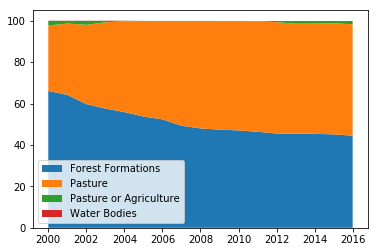

In [515]:
plt.stackplot(x_data,y_data, labels=labels)
plt.legend(loc='lower left')
plt.show()